# <font color=blue>OmegAlpes Tutorial 4 - Heat and Electricity combined system
`Prerequisite :` <a href="./OmegAlpes_Tutorial_1.ipynb">Tutorial 1,</a>
    <a href="./OmegAlpes_Tutorial_2.ipynb">Tutorial 2</a><br><br><br>
    
<font color=red>There are some parts in this tutorial that has already been covered in previous Tutorial 1 and 2 and will not be covered here.</font>
    
    In this tutorial, we will learn to add another type of energy (thermal) into our energy model. With these feature, we will explore the suggestion to consider utilizing heat from domestic hot water to reduce John electricity import.
    
   `Learning outcomes :`
>1. New vector in the model : thermal energy
2. Working with multiple nodes
3. Electrical to Heat conversion units
4. Processing results
   
    At the end of this tutorial, you will be able to find out whether adding thermal energy will be better outcome than the other solutions

<img src="./images/4-heat.JPG" width="550" height="150" >

In [1]:
from Python_Scripts.Omegalpes_tutorial_4 import *

    Similar to previous Tutorial 1. Try to have similar steps to have a good programming structure.

## Create time unit   

In [2]:
time = TimeUnit(periods=24*1, dt=1)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-01 23:00:00


    where :
    dt = 1 hour / 60 minutes since all of the production and consumption data is in 1-hour timestep
    period = 24 hours. You can have longer period if the data is available.
    
`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.time">time module</a>

## Create empty model
    

In [3]:
model = OptimisationModel(time=time, name='tutorial_4')

  
`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.optimisation.model">model module</a>

## Create energy unit

### Create fixed energy units

In [4]:
consumption_profile = open("data/house con 24.csv", "r")

house_cons_file = [p for p in map(float, consumption_profile)]

house_consumption = FixedConsumptionUnit(time, 'johns_consumption', p=house_cons_file, energy_type=elec)

Creating the johns_consumption.


In [5]:
pv_profile = open("data/pv prod 24.csv", "r")

pv_production_daily = [p for p in map(float, pv_profile)]

pv_production = FixedProductionUnit(time, name='pv_production', p=pv_production_daily ,energy_type=elec)

Creating the pv_production.


    Here, we have another new fixed consumption unit, which is domestic hot water

In [6]:
dhw_profile = pd.read_csv("data/DHW 24.csv", sep=';')

dhw_load = dhw_profile['kwh'].tolist()

dhw = FixedConsumptionUnit(time, name="domestic_hot_water", p=dhw_load, energy_type=thermal)

Creating the domestic_hot_water.


    As you can see, domestic hot water has energy type attribute of thermal
    
    Now, we have created 3 fixed energy units
<img src="./images/4-fixed.JPG" width="550" height="150">

### Create variable energy units

In [8]:
grid_import = VariableProductionUnit(time, 'grid_import',energy_type=elec, p_min=0)

grid_export = VariableConsumptionUnit(time, 'grid_export', energy_type=elec, p_min=0)

wm_profile = open("data/washer 24.csv", "r")

wm_cons_file = [p for p in map(float, wm_profile)]

wm_consumption = ShiftableConsumptionUnit(time, 'washing_machine_consumption', power_values=wm_cons_file,
                                          energy_type=elec)

Creating the grid_import.
Creating the grid_export.
Creating the washing_machine_consumption.


### Create conversion unit and storage unit
    Next, we create conversion unit, or ElectricalToThermalConversionUnit specificly to handle heat-electrical conversion.  This is a unit with an electricity consumption and a thermal production linked by and electrical to thermal ratio.
    
    In this case, this conversion unit is a water heater

In [9]:
water_heater = ElectricalToThermalConversionUnit(time, name="water_heater", elec_to_therm_ratio=0.9)

Creating the water_heater_therm_prod.
Creating the water_heater_elec_cons.
Creating the water_heater.


    Water heater unit has attributes of :
    - time that refers to timeunit as all other energy units
    - name as result label
    - electrical to tharmal conversion ratio

`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.units.conversion_units">conversion units module</a>

    The produced energy then will be stored in water tank. So, we create storage unit for this purpose

In [10]:
water_tank = StorageUnit(time, name="water_tank", self_disch_t=0.05, soc_min=0.2, energy_type=thermal,
                         ef_is_e0=True, capacity=6000)

Creating the water_tank.


    Storage unit has some new attributes : thermal energy type and defined capacity to represent the available space

    Now, we will add all these energy units to our model.
<img src="./images/4-allunit.JPG" width="700" height="500">
<br>

## Define model objective

In [11]:
grid_import.minimize_production()

`learn more optimization objective functions for energy units:`<a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.units.production_units">production units module</a> & <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.units.consumption_units"> consumption units module</a>

## Create energy nodes
    Now we create energy nodes, here is another challenge

In [18]:
%run Python_Scripts/quiz/quiz_tutorial41

    Although it is common practice to seperate nodes by energy type. There are also several other practicec, such as seperating nodes to simulate actors objectives. You can learn further about it to improve your level in OmegAlpes!
    
    Now, Let's create the nodes!

In [12]:
elec_node = EnergyNode(time, name="electrical_node", energy_type=elec)

elec_node.connect_units(pv_production, house_consumption, grid_import, grid_export, wm_consumption,
                    water_heater.elec_consumption_unit)

Creating the electrical_node.


In [13]:
heat_node = EnergyNode(time, name="heat_node", energy_type=thermal)
    
heat_node.connect_units(dhw, water_tank, water_heater.thermal_production_unit)

Creating the heat_node.


    Pay attention to each energy units connected to the node. Water heater as conversion unit has 2 parts which are connected to both node each. As explained before, two of these units are linked to each other to handle energy conversion. Let's observe below figure to have a better understanding of the model.
    
<img src="./images/4-heat.JPG" width="900" height="500">



`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.energy_nodes">energy nodes module</a>

## Add the energy nodes to the optimisation model
    Add all nodes to the model
    
    Remember to check that the timeunit is the same for the model and all the units

In [14]:
model.add_nodes(elec_node, heat_node)


--- Adding all variables to the model ---
Adding variable : pv_production_p
Adding variable : pv_production_e_tot
Adding variable : johns_consumption_p
Adding variable : johns_consumption_e_tot
Adding variable : grid_import_p
Adding variable : grid_import_e_tot
Adding variable : grid_import_u
Adding variable : grid_export_p
Adding variable : grid_export_e_tot
Adding variable : grid_export_u
Adding variable : washing_machine_consumption_p
Adding variable : washing_machine_consumption_e_tot
Adding variable : washing_machine_consumption_u
Adding variable : washing_machine_consumption_start_up
Adding variable : washing_machine_consumption_power_values
Adding variable : water_heater_elec_cons_p
Adding variable : water_heater_elec_cons_e_tot
Adding variable : water_heater_elec_cons_u
Adding variable : water_heater_therm_prod_p
Adding variable : water_heater_therm_prod_e_tot
Adding variable : water_heater_therm_prod_u
Adding variable : domestic_hot_water_p
Adding variable : domestic_hot_wate



`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.optimisation.model">optimisation model</a>

## Launch the optimisation

In [15]:
model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.2210831642150879 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : electrical_node
Updating unit : pv_production
	Quantity : p
	Quantity : e_tot
Updating unit : johns_consumption
	Quantity : p
	Quantity : e_tot
Updating unit : grid_import
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_export
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : washing_machine_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up
	Quantity : power_values
Updating unit : water_heater_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : water_heater
Updating unit : water_heater_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_node
Updating unit : domestic_hot_water
	Quantity : p
	Quantity : e_tot
Updating unit : water_tank
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : 



`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.optimisation.model">optimisation model</a>

## Plot result
    Plot energy flow at both nodes


Preparing to plot the energetic flows through the node electrical_node.
	Add power from pv_production.
	Add power from johns_consumption.
	Add power from grid_import.
	Add power from grid_export.
	Add power from washing_machine_consumption.
	Add power from water_heater_elec_cons.

Preparing to plot the energetic flows through the node heat_node.
	Add power from domestic_hot_water.
	Add power from water_tank.
	Add power from water_heater_therm_prod.


<module 'matplotlib.pyplot' from '/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>

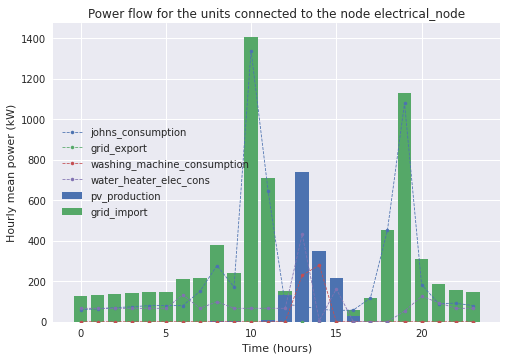

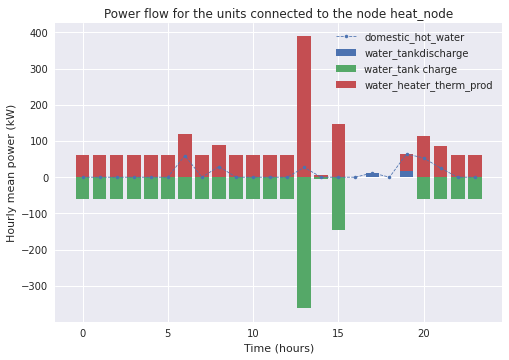

In [17]:
plot_node_energetic_flows(elec_node)
plot_node_energetic_flows(heat_node)

`learn more plotting functions:` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.utils.plots">plots module</a>

## Result processing
    Showing the result

`learn more plotting functions:` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.utils.plots">plots module</a>   


## Discussion
    What do you think about the result? What impact it does by adding heat conversion into the model? Compate the result with the other simulation you have done ! and try combining all level 2 skills you get and propose a better recommendation for John!

    Let us return to the dashboard so we can progress more in finding optimal solution for John with the other level 2 Tuto-rial. Don't forget to collect 1 level 2 magic word in this tutorial by finishing tasks in order to unlock stuffs! and the sixth and final magic word is 'OMEGALPES'
    
`[Link]` <a href="./OmegAlpes_tutorial.ipynb">Dashboard</a><br><br>